# Step 0 - Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1 - Read the data

In [ ]:
from google.colab import files          #Upload 01Exercise1.csv from the "Classification" folder of the course 
uploaded = files.upload()

Saving 01Exercise1.csv to 01Exercise1.csv


In [ ]:
data_original = pd.read_csv('01Exercise1.csv')
data = data_original.copy()
data.head()

,gender,married,ch,income,loanamt,status
0,Male,No,1.0,5849,NaN,Y
1,Male,Yes,1.0,4583,128.0,N
2,Male,Yes,1.0,3000,66.0,Y
3,Male,Yes,1.0,2583,120.0,Y
4,Male,No,1.0,6000,141.0,Y


# Step 2 - Prelim Analysis and Feature selection

##Remove irrelevant variables

In [ ]:
data = data.drop(['gender'], axis=1) #Bank cannot discreminate based on gender

##Null values

In [ ]:
data.isnull().sum(axis=0)

married     3
ch         50
income      0
loanamt    22
status      0
dtype: int64

In [ ]:
data.shape

(614, 5)

In [ ]:
#Remove any row that has at least 1 missing value
data = data.dropna()
data.shape

(541, 5)

##Normalization

In [ ]:
data.head(2)

,married,ch,income,loanamt,status
1,Yes,1.0,4583,128.0,N
2,Yes,1.0,3000,66.0,Y


In [ ]:
from scipy.stats import zscore

In [ ]:
Normalized_data = data.iloc[:, 2:4].apply(zscore)
Normalized_data.head(2)

,income,loanamt
1,-0.141051,-0.204324
2,-0.390889,-0.947889


In [ ]:
data.iloc[:, 2:4] = Normalized_data
data.head(2)

,married,ch,income,loanamt,status
1,Yes,1.0,-0.141051,-0.204324,N
2,Yes,1.0,-0.390889,-0.947889,Y


## Create Dummy Variables and drop first to avoid dummy variables trap

In [ ]:
data.dtypes  #variables to get dummie need to become categorical first

married     object
ch         float64
income     float64
loanamt    float64
status      object
dtype: object

In [ ]:
data = pd.get_dummies(data, drop_first=True) 

In [ ]:
data.head(2)

,ch,income,loanamt,married_Yes,status_Y
1,1.0,-0.141051,-0.204324,1,0
2,1.0,-0.390889,-0.947889,1,1


# Step 3 - Create Train and test split

In [ ]:
Y = data[ ['status_Y'] ]             #this way Y would remain a dataframe but Y=data['demand'] would be a pandas series
X = data.drop(['status_Y'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1234, stratify=Y)

# Step 4 - Fit the model and Predict

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

loan_regressor = LogisticRegression()
loan_regressor.fit(X_train, Y_train)


# Create Y Predictions
Y_predict = loan_regressor.predict(X_test)  # Y_predict would be a Pandas Series, lets convert it to Pandas DaraFrame
Y_predict = pd.DataFrame(Y_predict)


score = loan_regressor.score(X_test, Y_test)  #NOTE: Unlike Linear Regression in which .score returns the R-squared of the model,
                                             #       in the Logistic Regression, .score returns the "Accuracy" of the model according to the confusion matrix.
print('Model Score is:', score)

Model Score is: 0.7975460122699386


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#Step 5 - Evaluation using Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
cm = confusion_matrix(Y_test, Y_predict)
cm

#NOTE: As noted above, unlike Linear Regression in which .score returns the R-squared of the model,
#      in the Logistic Regression, .score returns the "Accuracy" of the model according to the confusion matrix.

# (21+109)/(21+109+3+30) = 0.7975 = score = loan_regressor.score(X_test, Y_test)   SEE ABOVE

array([[ 21,  30],
       [  3, 109]])

In [ ]:
cr = classification_report(Y_test, Y_predict)          #Precision: True positives / Positives predicted by model     109/(109+30)= 0.78
                                                       #Recall   : True positives / Actual positives                 109/(109+3)= 0.97
                                                       #Accuracy : TP + TN / all obs.
                                                       #F1Score  : 2*precision*Recall/ (precision+Recall)
print (cr)

              precision    recall  f1-score   support

           0       0.88      0.41      0.56        51
           1       0.78      0.97      0.87       112

    accuracy                           0.80       163
   macro avg       0.83      0.69      0.71       163
weighted avg       0.81      0.80      0.77       163



#Step 6- Modify the threshold for classification

In [ ]:
#Let's calculate the probability of each case; that is, the value on the Logistic Regression Curve:
Y_probability = loan_regressor.predict_proba(X_test)



#Now lets compare these probabilities(of different classes) with the Y_predict results
#You can see that, by default, wherever the probability of class 2 (that is Loan_status=Y) is above 0.5, Y_predict recognizes that as 1.
#Also, wherever the probability of class 2 (that is Loan_status=Y) is below 0.5, Y_predict recognizes that as 0.

print( Y_probability[0:7] )
Y_predict[0:7]

[[0.26549169 0.73450831]
 [0.23724238 0.76275762]
 [0.17146209 0.82853791]
 [0.82139785 0.17860215]
 [0.18415163 0.81584837]
 [0.85659074 0.14340926]
 [0.17383526 0.82616474]]


,0
0,1
1,1
2,1
3,0
4,1
5,0
6,1


In [ ]:
Y_predict_new = []
Threshold = 0.8

for i in range ( 0, len(Y_probability) ):
  if Y_probability[i][1] > Threshold:
    Y_predict_new.append(1)
  else:
    Y_predict_new.append(0)

In [ ]:
#Compared to the previous cm, now we have fewer False Positive because we became more strict (Threshold=0.8)
#But the True Positives have also decreased
cm = confusion_matrix(Y_test, Y_predict_new)
cm

array([[40, 11],
       [43, 69]])

In [ ]:
#Let's do it in a function form:

def cut_off(Y_probability, Threshold):

 Y_predict_new = []
 for i in range ( 0, len(Y_probability) ):
  if Y_probability[i][1] > Threshold:
    Y_predict_new.append(1)
  else:
    Y_predict_new.append(0)

 return Y_predict_new

In [ ]:
Y_probability = loan_regressor.predict_proba(X_test)
Y_predict_new = cut_off(Y_probability, 0.8)
Y_predict_new[0:5]

[0, 0, 1, 0, 1]

In [ ]:
cr = classification_report(Y_test, Y_predict)

print (cr)

              precision    recall  f1-score   support

           0       0.88      0.41      0.56        51
           1       0.78      0.97      0.87       112

    accuracy                           0.80       163
   macro avg       0.83      0.69      0.71       163
weighted avg       0.81      0.80      0.77       163



##ROC Curve & AUC

What kind of False Positive we should expect if we want a particular True Positive

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
FP_rate, TP_rate, Threshold = roc_curve(Y_test, Y_probability[:,1])

AUC = roc_auc_score(Y_test, Y_probability[:,1])
AUC


0.761204481792717

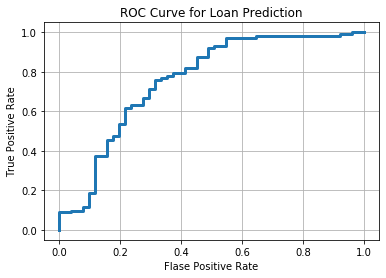

In [ ]:
plt.plot(FP_rate, TP_rate, linewidth=3 )
plt.xlabel('Flase Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Loan Prediction')
plt.grid()
plt.show()